#  项目：信用贷款违约预测

In [1]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple plotly

    100% |████████████████████████████████| 12.9MB 24kB/s eta 0:00:01    57% |██████████████████▍             | 7.4MB 4.9MB/s eta 0:00:02
  Running setup.py bdist_wheel for retrying ... done
  Stored in directory: /Users/yangxuan/Library/Caches/pip/wheels/bc/62/fb/cab5312f97c6f49f2cc145ca7bbb91b27fc91c1b1f5011603b
Successfully built retrying
You are using pip version 9.0.1, however version 20.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple cufflinks

You are using pip version 9.0.1, however version 20.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import pandas as pd
import plotly.offline as offline
offline.init_notebook_mode()
# from plotly import tools
# import plotly.tools as tls
# import squarify
# from mpl_toolkits.basemap import Basemap
# from numpy import array
# from matplotlib import cm

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()
plt.style.use('fivethirtyeight')


In [2]:
app_train=pd.read_csv('file:///F:/BaiduNetdiskDownload/信用风险数据集/application_train.csv')
app_test = pd.read_csv('file:///F:/BaiduNetdiskDownload/信用风险数据集/application_test.csv')


# 二、主训练集探索

In [6]:
app_train.head() 


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

              ...              FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                             0                0   
1             ...                             0                0   
2             ...                             0                0   
3             ...                             0                0   
4             ...                             0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        NaN   
4                0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       NaN                         NaN   
4                       0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         1.0  
1                         0.0  
2                         0.0  
3                         NaN  
4                         0.0  

[5 rows x 122 columns]

## 1. 数据探索
首先我们需要对数据做一些探索，
一是了解数据的缺失值情况、异常值情况，以便做对应的数据清洗。
二是了解一下违约贷款和正常贷款用户画像的区别，加深对业务的理解，为我们后面的数据分析（特征工程）展开打基础


### 异常值检测


In [7]:
#定义缺失值检测函数
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

数据一共有122列，有67列存在缺失情况，最高缺失值的列缺失度为69.9%，对缺失值的处理在房价预测案例中已经提到过，对于缺失值的处理一是我们可以采用XGBoost这种能够自动处理缺失值的模型，这样我们就无需处理缺失值。二是可以进行填补，三是可以对缺失值较高的列直接删除

可以发现前面的几列特征缺失度的都是一样的，并且它们都是属于房屋信息，根据这个规律我们可以猜测用户缺失房屋信息可能是因为某种特定原因导致的，而不是随机缺失，这点我们会在后面的特征工程用上。

In [82]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 273 columns.
There are 218 columns that have missing values.


Missing Values  \
client_bureau_balance_STATUS_0_count_norm_max           215280   
client_bureau_balance_MONTHS_BALANCE_min_mean           215280   
client_bureau_balance_STATUS_4_count_norm_mean          215280   
client_bureau_balance_STATUS_4_count_norm_max           215280   
client_bureau_balance_STATUS_4_count_norm_min           215280   
client_bureau_balance_MONTHS_BALANCE_min_min            215280   
client_bureau_balance_STATUS_1_count_mean               215280   
client_bureau_balance_STATUS_5_count_mean               215280   
client_bureau_balance_STATUS_5_count_max                215280   
client_bureau_balance_STATUS_5_count_min                215280   
client_bureau_balance_MONTHS_BALANCE_sum_mean           215280   
client_bureau_balance_STATUS_5_count_norm_mean          215280   
client_bureau_balance_STATUS_5_count_norm_max           215280   
client_bureau_balance_STATUS_5_count_norm_min           215280   
client_bureau_balance_MONTHS_BALANCE_sum_max            215280   
client_bureau_balance_STATUS_0_count_norm_mean          215280   
client_bureau_balance_STATUS_C_count_mean               215280   
client_bureau_balance_STATUS_C_count_max                215280   
client_bureau_balance_STATUS_C_count_min                215280   
client_bureau_balance_MONTHS_BALANCE_sum_min            215280   

                                                % of Total Values  
client_bureau_balance_STATUS_0_count_norm_max                70.0  
client_bureau_balance_MONTHS_BALANCE_min_mean                70.0  
client_bureau_balance_STATUS_4_count_norm_mean               70.0  
client_bureau_balance_STATUS_4_count_norm_max                70.0  
client_bureau_balance_STATUS_4_count_norm_min                70.0  
client_bureau_balance_MONTHS_BALANCE_min_min                 70.0  
client_bureau_balance_STATUS_1_count_mean                    70.0  
client_bureau_balance_STATUS_5_count_mean                    70.0  
client_bureau_balance_STATUS_5_count_max                     70.0  
client_bureau_balance_STATUS_5_count_min                     70.0  
client_bureau_balance_MONTHS_BALANCE_sum_mean                70.0  
client_bureau_balance_STATUS_5_count_norm_mean               70.0  
client_bureau_balance_STATUS_5_count_norm_max                70.0  
client_bureau_balance_STATUS_5_count_norm_min                70.0  
client_bureau_balance_MONTHS_BALANCE_sum_max                 70.0  
client_bureau_balance_STATUS_0_count_norm_mean               70.0  
client_bureau_balance_STATUS_C_count_mean                    70.0  
client_bureau_balance_STATUS_C_count_max                     70.0  
client_bureau_balance_STATUS_C_count_min                     70.0  
client_bureau_balance_MONTHS_BALANCE_sum_min                 70.0

### 异常值探索
对主训练集进行一些异常值的探索，这次异常值探索，我们采取最简单的描述统计的方法，即查看特征的均值、极大值、极小值等信息判断是否有异常值




查看用户年龄的数据分布情况（因为数据中，年龄的数值是负数，反映的是申请贷款前，这个用户活了多少天，所以这里我除了负365做了下处理）,发现数据的分布还是比较正常的，最大年龄69岁，最小年龄20岁，没有很异常的数字

In [84]:
(app_train['DAYS_BIRTH'] / -365).describe()


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

查看用户的工作时间分布情况发现（同样工作时间也是负数，所以我除了负365），最小值是-1000年，这里的-1000年明显是一个异常数据，没有人的工作时间是负数的，这可能是个异常值

In [85]:
(app_train['DAYS_EMPLOYED']/-365).describe()


count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

看一下用户受工作时间的数据分布情况，发现所有的异常值都是一个值，365243，对于这个异常值我的理解是它可能是代表缺失值，所以我的选择是将这个异常值用空值去替换，这样可以保留这个信息，又抹去了异常值，替换之后我们再看一下工作时间的分布情况，正常了很多


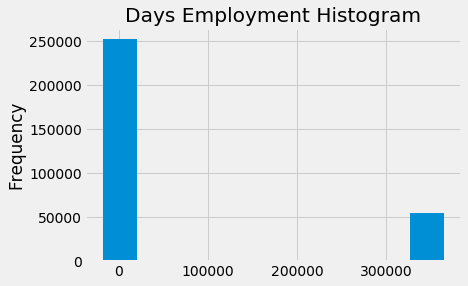

In [86]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');


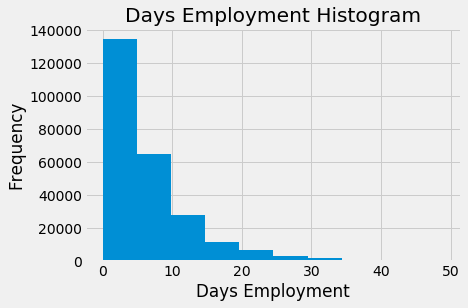

In [87]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
(app_train['DAYS_EMPLOYED']/-365).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

## 违约用户画像探索 

这部分分析的目标主要是查看违约用户和非违约用户的特征分布情况，目标是对违约用户的画像建立一个基本的了解，为后续特征工程打下基础。比如数据集里面有很多字段，包括性别、年龄、工作时间等等，那么是男性更容易违约还是女性？是年龄大的人更容易违约还是年龄小的人？查看这些数据的话，可以帮助我们对数据有更好的理解，同时这也是我们面试中可以表达的部分



In [89]:
#这一段是画图代码，无需弄懂
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();
    
def plot_distribution(var):
    
    i = 0
    t1 = app_train.loc[app_train['TARGET'] != 0]
    t0 = app_train.loc[app_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

首先来看一下男性和女性用户的违约率情况，发现男性用户违约率更高，男性用户违约率为10%，女性为7%


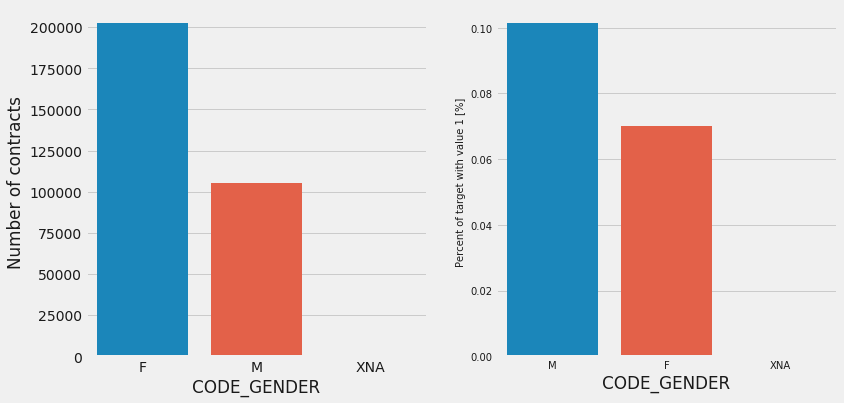

In [90]:
plot_stats('CODE_GENDER')

下面我们再来看一下违约用户和正常用户的年龄分布情况，因为年龄是连续型变量，和性别不同，所以我们使用分布图去看年龄的分布情况，通过数据分布我们可以看到，违约用户年轻用户分布更多，所以我们可以推断的结论是用户年龄越小，违约的可能性越大

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



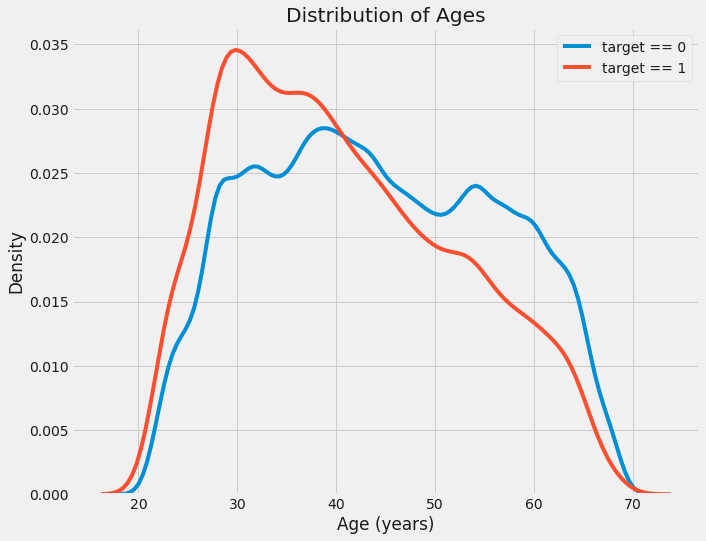

In [91]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

我们可以对用户的年龄进行分捅，进一步观察观察不同年龄段用户的违约概率，发现确实是用户年龄越小，违约的可能性越高


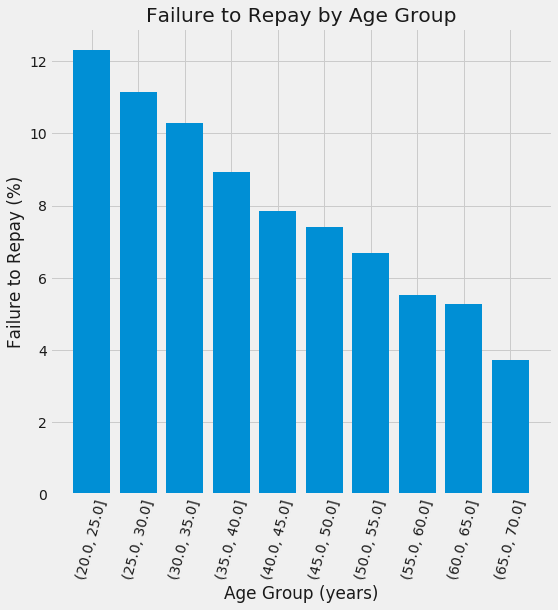

In [92]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_groups  = age_data.groupby('YEARS_BINNED').mean()
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

再来看一下不同贷款类型的违约率情况，对于现金贷款和流动资金循坏贷款，现金贷款的违约率更高


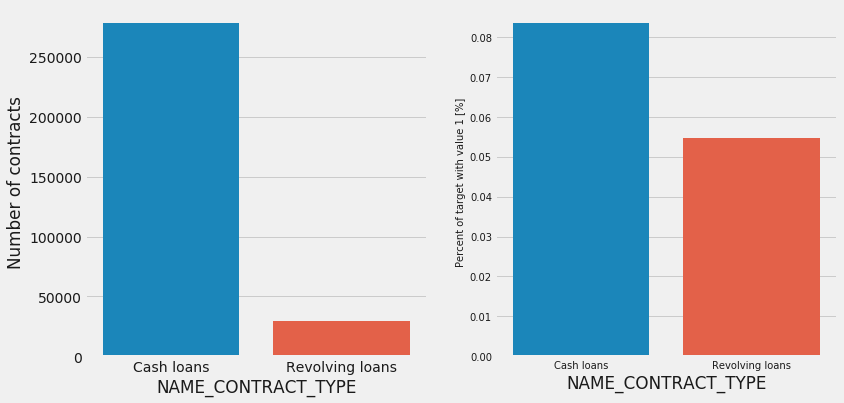

In [93]:
plot_stats('NAME_CONTRACT_TYPE')


看下用户有没有房和车对违约率的影响，发现没有车和房的人违约率更高，但相差并不是很大


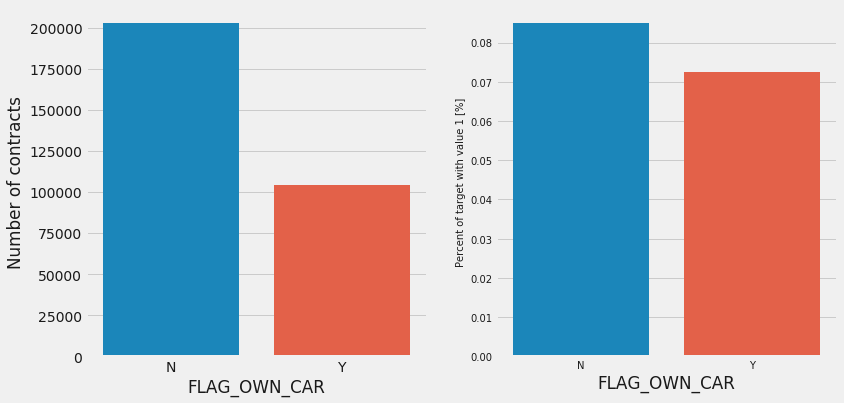

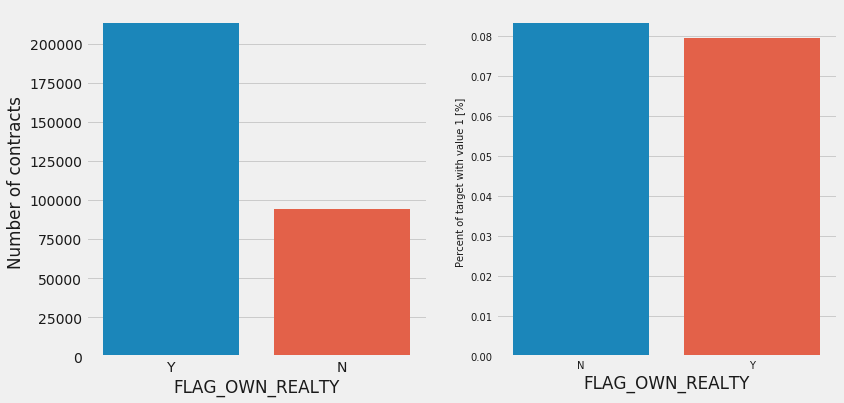

In [94]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

从家庭情况看，申请的用户大多已经结婚，单身和世俗结婚的违约率较高，寡居的违约率最低（civil marriage世俗结婚是西方婚姻的一种，和宗教婚姻相反，了解下就可以）


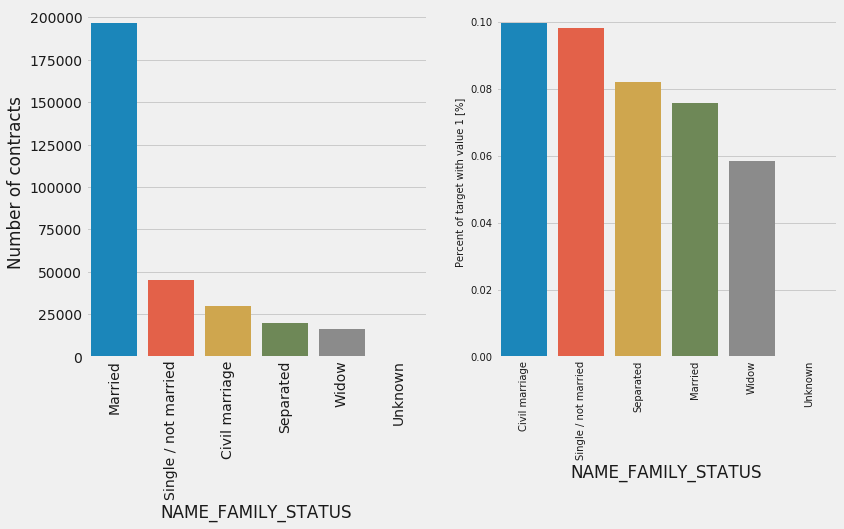

In [95]:
plot_stats('NAME_FAMILY_STATUS',True, True)


看一下子女信息，大部分申请者没有孩子或孩子在3个以下，孩子越多的家庭违约率越高，发现对于有9、11个孩子的家庭违约率达到了100%（和样本少也有关系


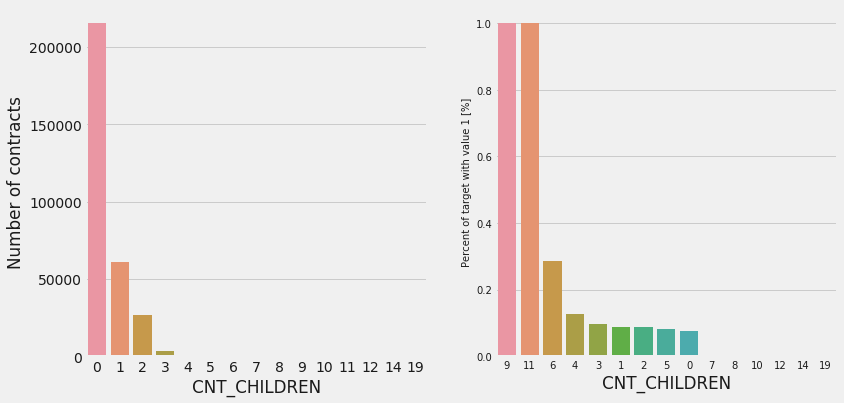

In [96]:
plot_stats('CNT_CHILDREN')


根据申请者的收入类型区分，可以发现休产假和没有工作的人违约率较高，在35%以上，对于这两类人群放款需较为谨慎


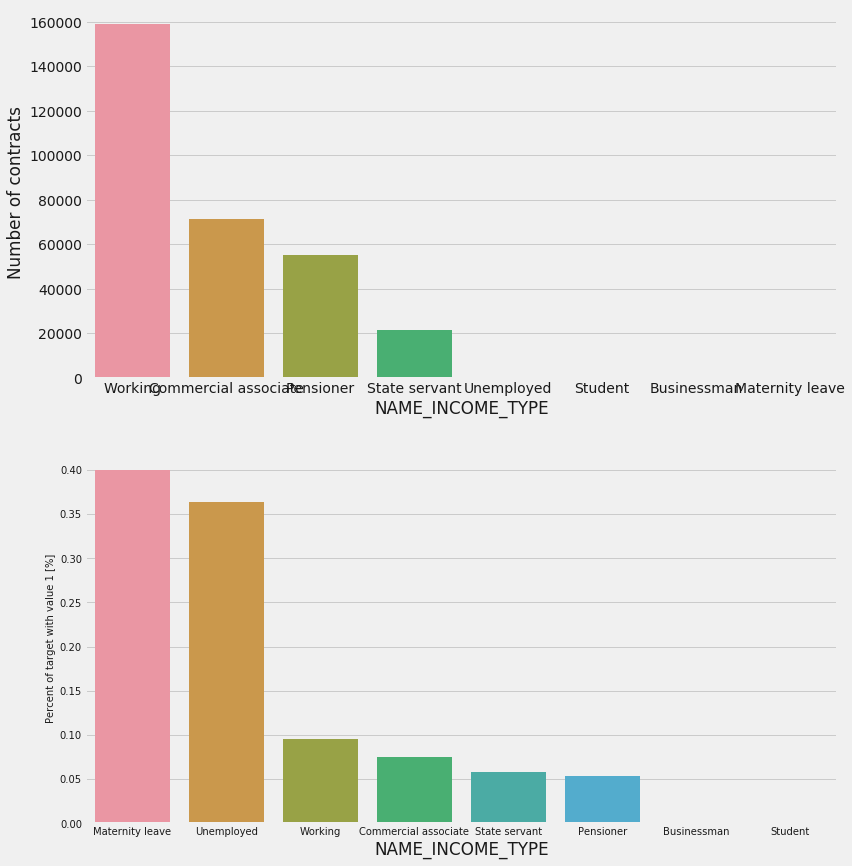

In [97]:
plot_stats('NAME_INCOME_TYPE',False,False)


从职业来看，越相对收入较低、不稳定的职业违约率越高，比如低廉劳动力、司机、理发师，而像会计、高科技员工等具有稳定高收入的职业违约率就较低


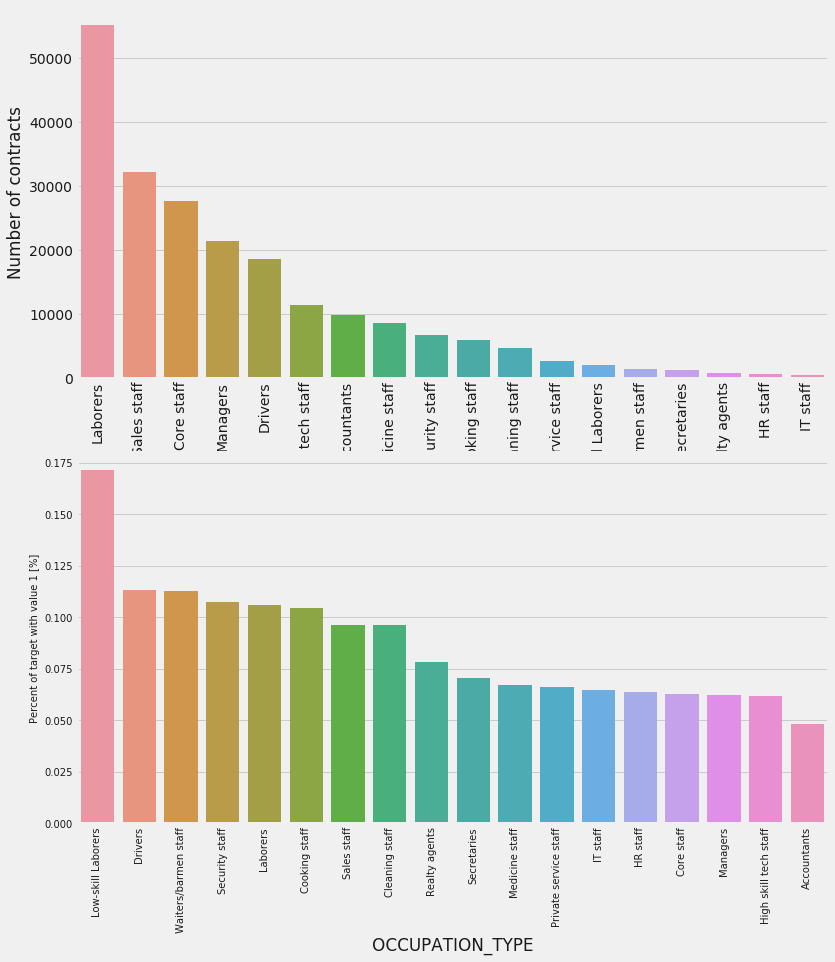

In [98]:
plot_stats('OCCUPATION_TYPE',True, False)


贷款申请人受教育程度大多为中学，学历越低越容易违约


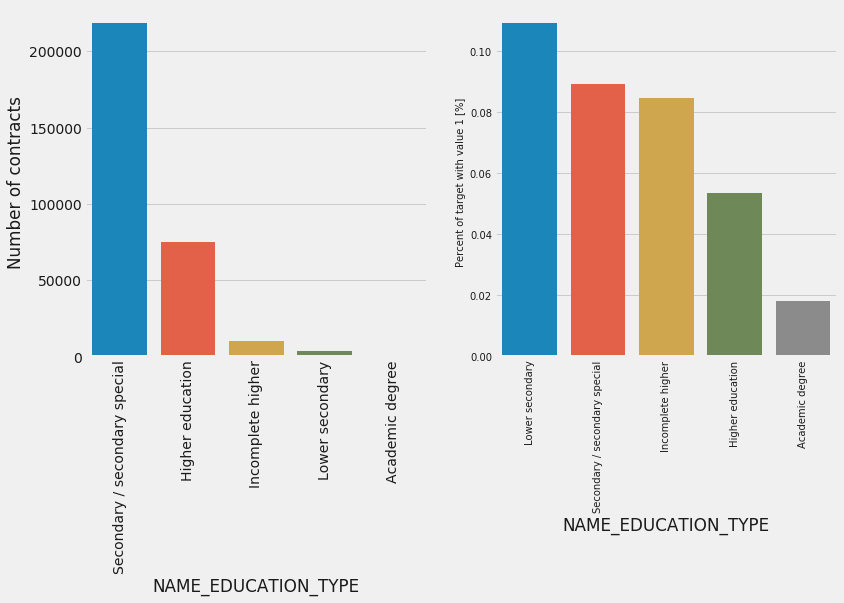

In [99]:
plot_stats('NAME_EDUCATION_TYPE',True)


## 特征工程

接下来我们通过对特征的一些理解，尝试做出一些新的特征


1. CREDIT_INCOME_PERCENT: 贷款金额/客户收入，预期是这个比值越大，说明贷款金额大于用户的收入，用户违约的可能性就越大

2. ANNUITY_INCOME_PERCENT: 贷款的每年还款金额/客户收入，逻辑与上面一致

3. CREDIT_TERM: 贷款的每年还款金额/贷款金额，贷款的还款周期，猜测还款周期短的贷款，用户的短期压力可能会比较大，违约概率高

4. DAYS_EMPLOYED_PERCENT: 用户工作时间/用户年龄

5. INCOME_PER_CHILD：客户收入/孩子数量，客户的收入平均到每个孩子身上，同样的收入，如果这个人的家庭很大，孩子很多，那么他的负担可能比较重，违约的可能性可能更高

6. HAS_HOUSE_INFORMATION : 大家还记得我们在处理缺失值时提到的规律吗， 这里我们根据客户是否有缺失房屋信息设计一个二分类特征，如果未缺失的话是1，缺失的是0


In [7]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
app_train_domain['INCOME_PER_CHILD'] = app_train_domain['AMT_INCOME_TOTAL'] / app_train_domain['CNT_CHILDREN']
app_train_domain['HAS_HOUSE_INFORMATION'] = app_train_domain['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)




对我们设计出来的连续性特征查看它们在违约用户和非违约用户中的分布情况，可以发现除CREDIT_TERM这个特征外，其他的特征区分度似乎都不是很明显，大家不需要灰心，这个是很正常的现象，虽然现在看起来区分度较小，但我们可以放到模型中再看一下效果

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in greater

D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in less



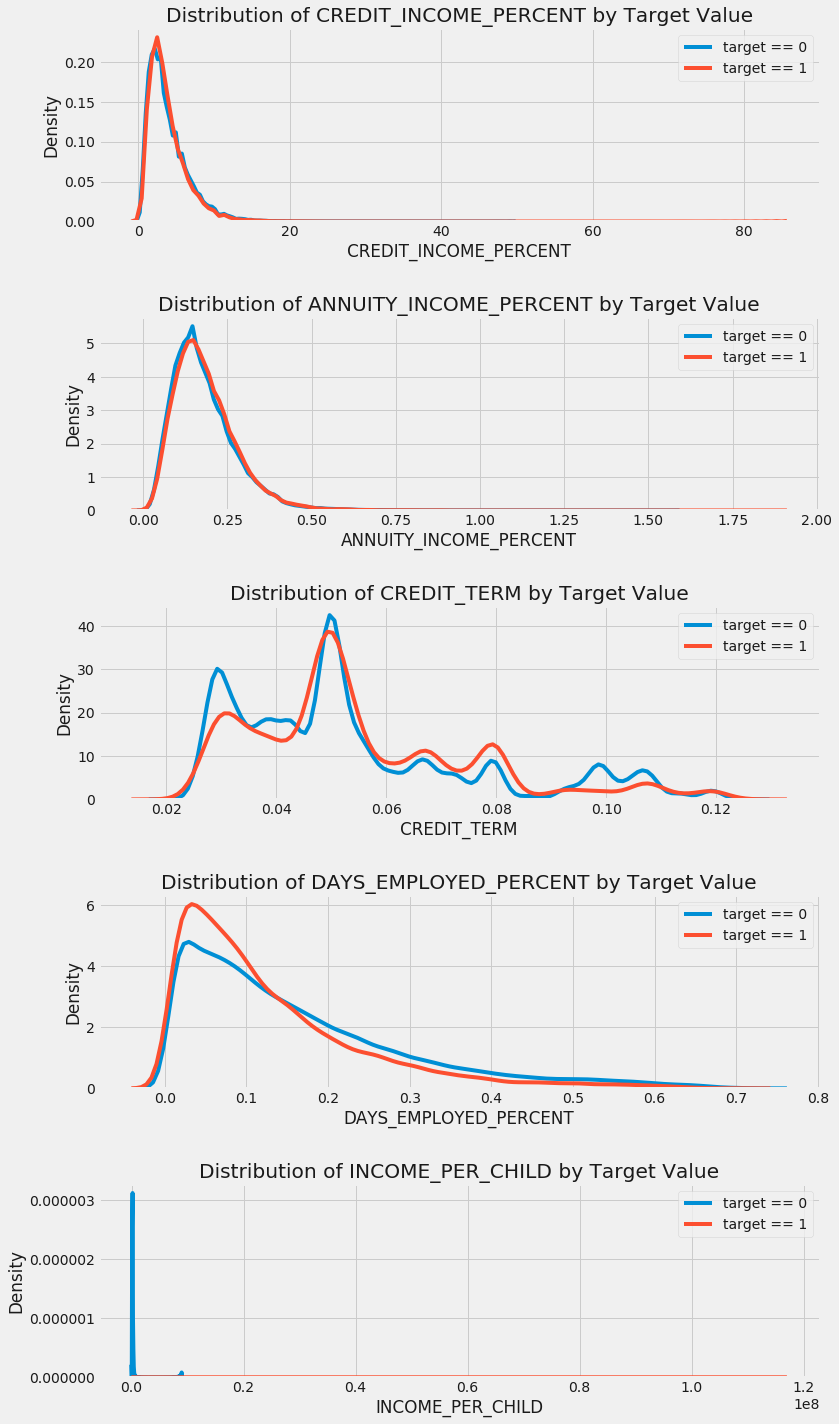

In [102]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT','INCOME_PER_CHILD']):
    
    # create a new subplot for each source
    plt.subplot(5, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [104]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_train_domain[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_train_domain[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

再来看一下通过缺失值设计的这个特征，通过下图我们可以看到，缺失房屋信息的用户违约概率要明显高于未缺失用户，这在我们模型的预测中可以算是一个比较有效的特征了

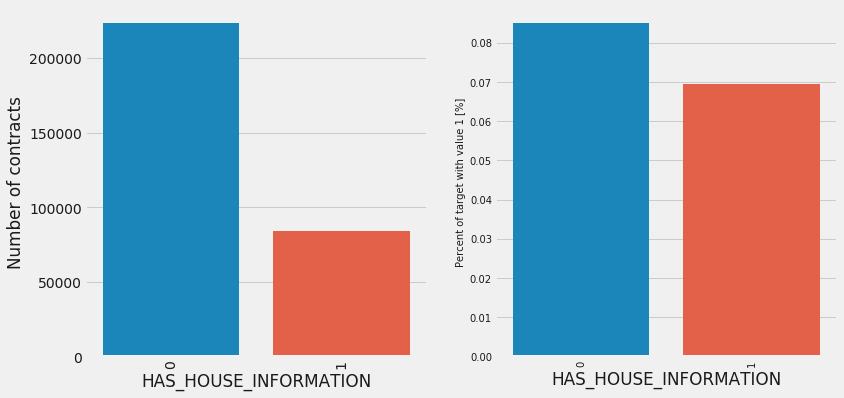

In [105]:
plot_stats('HAS_HOUSE_INFORMATION',True)


对测试集做同样的处理

In [8]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']
app_test_domain['INCOME_PER_CHILD'] = app_test_domain['AMT_INCOME_TOTAL'] / app_test_domain['CNT_CHILDREN']
app_test_domain['HAS_HOUSE_INFORMATION'] = app_test_domain['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)



## 建模预测

最后，我们利用现有的主数据集先进行一次建模预测，模型的话选择是LGB模型，LGB模型的话原理比较复杂，我个人也没有太深的涉及，模型本身的话也不是我们项目的重点，大家在面试时候一句话带过即可，下面代码的话也不太需要关注，感兴趣的同学可以了解一下下面的文章

lightgbm,xgboost,gbdt的区别与联系 https://www.cnblogs.com/mata123/p/7440774.html

In [33]:
#mac的同学可能会出错，可以尝试在anaconda里面装一下
!pip install lightgbm 

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

In [5]:

def model(features, test_features, encoding = 'ohe', n_folds = 5):

    
    #Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [13]:
submission, fi, metrics = model(app_train_domain, app_test_domain)
print('Baseline metrics')
print(metrics)

del app_train_domain,app_test_domain
gc.collect

Training Data Shape:  (307511, 247)
Testing Data Shape:  (48744, 247)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804538	train's binary_logloss: 0.541681	valid's auc: 0.762542	valid's binary_logloss: 0.557109
Early stopping, best iteration is:
[220]	train's auc: 0.807671	train's binary_logloss: 0.538492	valid's auc: 0.762693	valid's binary_logloss: 0.555223
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804189	train's binary_logloss: 0.542175	valid's auc: 0.765804	valid's binary_logloss: 0.557781
Early stopping, best iteration is:
[221]	train's auc: 0.807867	train's binary_logloss: 0.538406	valid's auc: 0.766202	valid's binary_logloss: 0.555368
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.803666	train's binary_logloss: 0.54313	valid's auc: 0.769723	valid's binary_logloss: 0.558218
Early stopping, best iteration is:
[217]	train's auc: 0.806684	train's binary_logloss: 0.540066

<function gc.collect(generation=2)>

通过lgb自带的函数查看特征的重要性

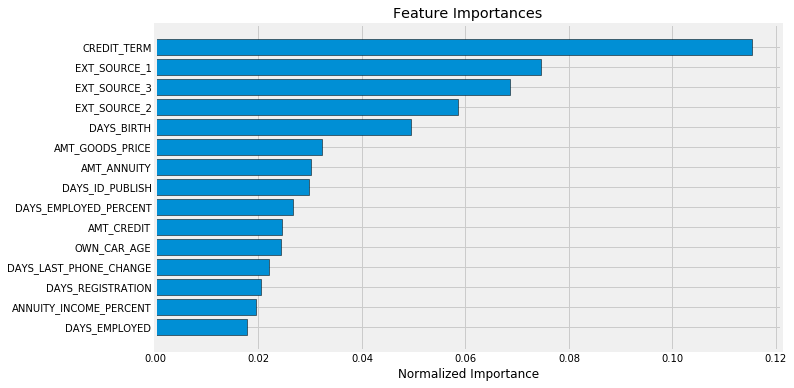

In [14]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
fi_sorted = plot_feature_importances(fi)


# 三、利用其他数据集信息

在上面的分析中我们其实已经完成了类测房价案例的一次完整的分析过程，但对于正式比赛来说，除了一个主要训练集和预测集之外，往往还会有一些辅助训练集，这些训练集和主训练集可以通过对应的键进行关联，我们一般需要从这些辅助训练集中提取出一些信息把它们作为新的特征加入到主训练集中,下面我们来一起看一下

## 信用局信息
首先是信用局信息，数据集中的每一行代表的是主训练集中的申请人曾经在其他金融机构申请的贷款信息，可以看到数据集中同样有一列是“SK_ID_CURR',和主训练集中的列一致，我们可以通过这一列去把辅助训练集和主训练集做left join，但需要注意的一点是，一个SK_ID_CURR可能会对应多个SK_ID_BUREAU，即一个申请人如果在其他金融机构曾经有多条贷款信息的话，这里就会有多条记录，因为模型训练每个申请人在数据集中只能有一条记录，所以说我们不能直接把辅助训练集去和主训练集join，一般来说需要去计算一些统计特征（groupby操作）

In [3]:
bureau = pd.read_csv('file:///F:/BaiduNetdiskDownload/信用风险数据集/bureau.csv')
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

那么啥是统计特征？统计特征就是统计上的一些常用计算，比如count、avg、min、max、median等等，下面我们来看一个例子，上面我们提到过一个申请人如果在其他金融机构曾经有多条贷款信息的话，数据集里就会有多条记录，根据这点我们可能会想到，一个申请人在其他金融机构的历史贷款申请数越多，是不是可能说明这个人的信用可能越好？因为他的信用已经在其他金融机构那里被验证过，这就和校招面试中hr问你有没有拿到其他什么公司的offer一个道理，如果你有其他大厂的offer，那么说明你本身也是被其他大厂验证过的，可信度会相对更高

In [110]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()
#针对每个贷款申请人计算他们在其他金融机构历史上的贷款数量

SK_ID_CURR  previous_loan_counts
0      100001                     7
1      100002                     8
2      100003                     4
3      100004                     2
4      100005                     3

然后我们再把计算出来的统计特征和主训练集做left join，可以看到我们的统计特征就出现在了最后一列

In [111]:
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
app_train['previous_loan_counts'] = app_train['previous_loan_counts'].fillna(0)
app_train.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002         Cash loans           M            N               Y   
1      100003         Cash loans           F            N               N   
2      100004    Revolving loans           M            Y               Y   
3      100006         Cash loans           F            N               Y   
4      100007         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

           ...          client_bureau_balance_STATUS_X_count_max  \
0          ...                                               3.0   
1          ...                                               NaN   
2          ...                                               NaN   
3          ...                                               NaN   
4          ...                                               NaN   

  client_bureau_balance_STATUS_X_count_min  \
0                                      0.0   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

  client_bureau_balance_STATUS_X_count_sum  \
0                                     15.0   
1                                      0.0   
2                                      0.0   
3                                      NaN   
4                                      0.0   

  client_bureau_balance_STATUS_X_count_norm_count  \
0                                             8.0   
1                                             0.0   
2                                             0.0   
3                                             NaN   
4                                             0.0   

  client_bureau_balance_STATUS_X_count_norm_mean  \
0                                       0.161932   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   client_bureau_balance_STATUS_X_count_norm_max  \
0                                            0.5   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   client_bureau_balance_STATUS_X_count_norm_min  \
0                                            0.0   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   client_bureau_balance_STATUS_X_count_norm_sum  TARGET  previous_loan_counts  
0                                       1.295455       1                   8.0  
1                                       0.000000       0                   4.0  
2                                       0.000000       0                   2.0  
3                                            NaN       0                   0.0  
4                                       0.000000       0                   1.0  

[5 rows x 274 columns]

在做出新特征后，我们往往还需要检验新特征是否对预测有区分度，不是所有的新特征都是有用的，有些没有用的特征加到数据集里反而会降低预测值，通过查看违约和非违约用户previous_loan_counts的统计属性发现，虽然非违约用户的平均贷款申请数量要略多于违约用户，但差异很小，所以其实很难判断这个特征对预测是否是有用的，我们可以尝试在做一些更多的特征

In [13]:
print(app_train[app_train.TARGET==1]['previous_loan_counts'].describe())
print(app_train[app_train.TARGET==0]['previous_loan_counts'].describe())

count    24825.000000
mean         4.613092
std          4.732792
min          0.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         55.000000
Name: previous_loan_counts, dtype: float64
count    282686.000000
mean          4.778464
std           4.474586
min           0.000000
25%           1.000000
50%           4.000000
75%           7.000000
max         116.000000
Name: previous_loan_counts, dtype: float64


定义一个查看分布的函数，以后再做出新特征时，我们可以用这个函数快速查看新的特征在违约用户和非违约用户中的分布情况

In [14]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; u

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


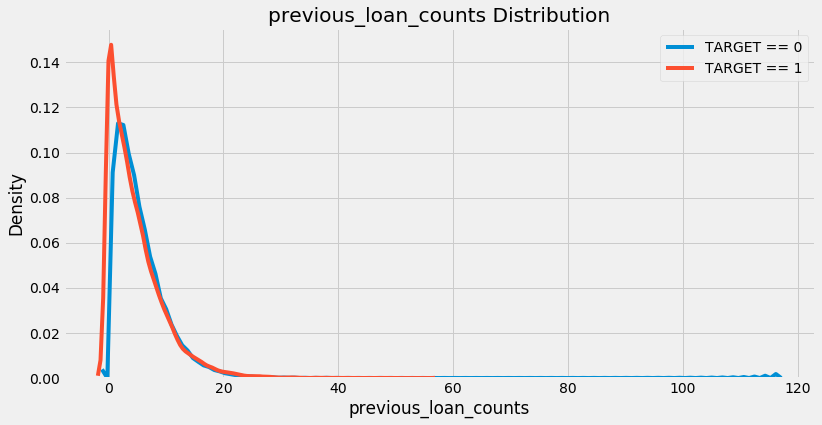

In [17]:

kde_target('previous_loan_counts', app_train)


### 连续型变量特征提取
对于连续型变量，我们都可以采用计算它们的统计值来作为特征，为了快速计算出大量统计特征，我们可以结合采用python中的groupby和agg函数

In [18]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                 ...    DAYS_CREDIT_UPDATE                               \
  mean max min   ...                 count        mean  max   min   sum   
0  0.0   0   0   ...                     7  -93.142857   -6  -155  -652   
1  0.0   0   0   ...                     8 -499.875000   -7 -1185 -3999   
2  0.0   0   0   ...                     4 -816.000000  -43 -2131 -3264   
3  0.0   0   0   ...                     2 -532.000000 -382  -682 -1064   
4  0.0   0   0   ...                     3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

通过上面的函数我们快速计算出了大量统计特征，但可以看到上面数据的展示形式会比较类似excel中的数据透视表，我们还需要做其形式做一些变换，对每一列重新命名

In [20]:
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [21]:
bureau_agg.columns = columns
bureau_agg.head()

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7              -735.000000   
1      100002                         8              -874.000000   
2      100003                         4             -1400.750000   
3      100004                         2              -867.000000   
4      100005                         3              -190.666667   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   
3                    -408                   -1326                   -1734   
4                     -62                    -373                    -572   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   
3                                2                             0.0   
4                                3                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

            ...            bureau_DAYS_CREDIT_UPDATE_count  \
0           ...                                          7   
1           ...                                          8   
2           ...                                          4   
3           ...                                          2   
4           ...                                          3   

   bureau_DAYS_CREDIT_UPDATE_mean  bureau_DAYS_CREDIT_UPDATE_max  \
0                      -93.142857                             -6   
1                     -499.875000                             -7   
2                     -816.000000                            -43   
3                     -532.000000                           -382   
4                      -54.333333                            -11   

   bureau_DAYS_CREDIT_UPDATE_min  bureau_DAYS_CREDIT_UPDATE_sum  \
0                           -155                           -652   
1                          -1185                          -3999   
2                          -2131                          -3264   
3                           -682                          -1064   
4                           -121                           -163   

   bureau_AMT_ANNUITY_count  bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  \
0                         7              3545.357143                 10822.5   
1                         7                 0.000000                     0.0   
2                         0                      NaN                     NaN   
3                         0                      NaN                     NaN   
4                         3              1420.500000                  4261.5   

   bureau_AMT_ANNUITY_min  bureau_AMT_ANNUITY_sum  
0                     0.0                 24817.5  
1                     0.0                     0.0  
2                     NaN                     0.0  
3                     NaN                     0.0  
4                     0.0                  4261.5  

[5 rows x 61 columns]

同样把新制作的特征和主数据集进行left join

In [22]:
app_train = app_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

            ...            bureau_DAYS_CREDIT_UPDATE_count  \
0           ...                                        8.0   
1           ...                                        4.0   
2           ...                                        2.0   
3           ...                                        NaN   
4           ...                                        1.0   

  bureau_DAYS_CREDIT_UPDATE_mean bureau_DAYS_CREDIT_UPDATE_max  \
0                       -499.875                          -7.0   
1                       -816.000                         -43.0   
2                       -532.000                        -382.0   
3                            NaN                           NaN   
4                       -783.000                        -783.0   

  bureau_DAYS_CREDIT_UPDATE_min bureau_DAYS_CREDIT_UPDATE_sum  \
0                       -1185.0                       -3999.0   
1                       -2131.0                       -3264.0   
2                        -682.0                       -1064.0   
3                           NaN                           NaN   
4                        -783.0                        -783.0   

  bureau_AMT_ANNUITY_count  bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  \
0                      7.0                      0.0                     0.0   
1                      0.0                      NaN                     NaN   
2                      0.0                      NaN                     NaN   
3                      NaN                      NaN                     NaN   
4                      0.0                      NaN                     NaN   

   bureau_AMT_ANNUITY_min  bureau_AMT_ANNUITY_sum  
0                     0.0                     0.0  
1                     NaN                     0.0  
2                     NaN                     0.0  
3                     NaN                     NaN  
4                     NaN                     0.0  

[5 rows x 183 columns]

上面我们一口气制作了大量统计特征，同样，我们也要去考察一下它们对模型预测的能力，如果再像之前一个个的去查看分布的话会比较麻烦，我们可以查看这些特征和Y值的相关性系数来做一个快速的判断，虽然不够准确，但可以作为一个大概的参考

In [25]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = app_train['TARGET'].corr(app_train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))

下方函数输出相关性绝对值前15的特征，可以看到DAYS_CREDIT_MEAN与Y值的正相关性最强，官方说明文档给出的含义是“How many days before current application did client apply for Credit Bureau credit”，即申请人在信用局开户的平均历史天数，大家可以看到因为数据集中这个值是负数，所以含义其实是用户的开户时间越长，历史信用记录的时间越久越不容易违约



In [26]:
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392113),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102051),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758661),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483543),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329046),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992161599),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325547)]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in greater

D:\Anaconda3\lib\site-p

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


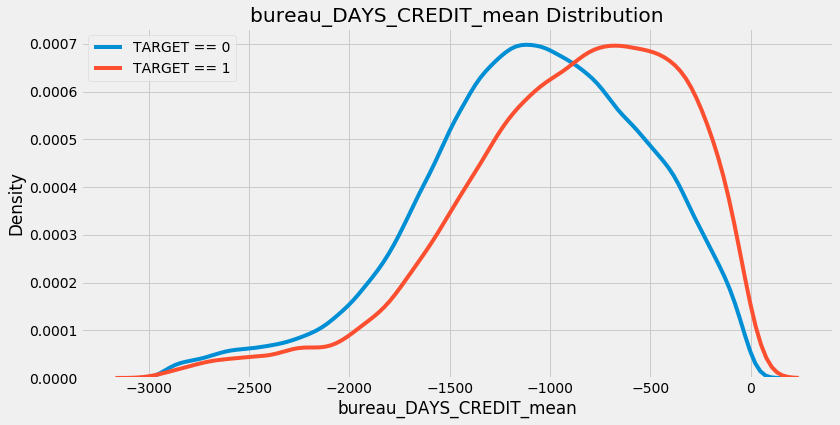

In [28]:
kde_target('bureau_DAYS_CREDIT_mean', app_train)
#有一定区分度

为了能快速把上面计算连续型变量特征的方法应用到其他数据集中，我们定义一个函数来完成上面所有的步骤

In [15]:
def agg_numeric(df, group_var, df_name):
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [36]:
#看下效果，一个函数完成了上面所有的步骤
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7              -735.000000   
1      100002                         8              -874.000000   
2      100003                         4             -1400.750000   
3      100004                         2              -867.000000   
4      100005                         3              -190.666667   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   
3                    -408                   -1326                   -1734   
4                     -62                    -373                    -572   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   
3                                2                             0.0   
4                                3                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

            ...            bureau_DAYS_CREDIT_UPDATE_count  \
0           ...                                          7   
1           ...                                          8   
2           ...                                          4   
3           ...                                          2   
4           ...                                          3   

   bureau_DAYS_CREDIT_UPDATE_mean  bureau_DAYS_CREDIT_UPDATE_max  \
0                      -93.142857                             -6   
1                     -499.875000                             -7   
2                     -816.000000                            -43   
3                     -532.000000                           -382   
4                      -54.333333                            -11   

   bureau_DAYS_CREDIT_UPDATE_min  bureau_DAYS_CREDIT_UPDATE_sum  \
0                           -155                           -652   
1                          -1185                          -3999   
2                          -2131                          -3264   
3                           -682                          -1064   
4                           -121                           -163   

   bureau_AMT_ANNUITY_count  bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  \
0                         7              3545.357143                 10822.5   
1                         7                 0.000000                     0.0   
2                         0                      NaN                     NaN   
3                         0                      NaN                     NaN   
4                         3              1420.500000                  4261.5   

   bureau_AMT_ANNUITY_min  bureau_AMT_ANNUITY_sum  
0                     0.0                 24817.5  
1                     0.0                     0.0  
2                     NaN                     0.0  
3                     NaN                     0.0  
4                     0.0                  4261.5  

[5 rows x 61 columns]

In [37]:
#同样再定义一个相关性计算函数
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

### 离散型变量特征提取
对于连续型变量我们可以采用计算统计值的方法去做特征，那么对于离散型变量呢？对于离散型变量我们不能计算它们的统计特征，但我们可以计算离散型特征中每个取值的个数，通过这种方式来获取到一些信息，来看下面的例子

原始数据是这样的
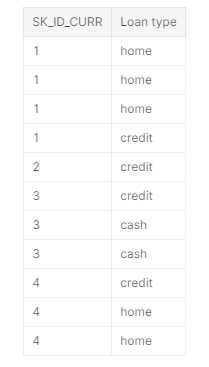

最终我们希望达到的效果是
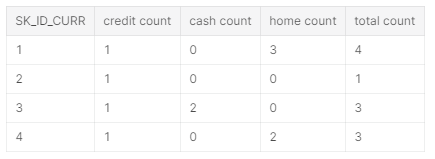

除此之外，我们还可以计算每个用户的每个值的个数在整体中的比例
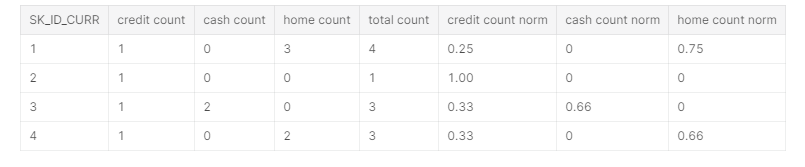

为了达到最终上面图片的效果，下面我们就来一起看一下如何去做，首先先把数据集中的离散特征变成哑变量

In [29]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  CREDIT_ACTIVE_Closed  \
0                     0                       0                     1   
1                     1                       0                     0   
2                     1                       0                     0   
3                     1                       0                     0   
4                     1                       0                     0   

   CREDIT_ACTIVE_Sold  CREDIT_CURRENCY_currency 1  CREDIT_CURRENCY_currency 2  \
0                   0                           1                           0   
1                   0                           1                           0   
2                   0                           1                           0   
3                   0                           1                           0   
4                   0                           1                           0   

   CREDIT_CURRENCY_currency 3  CREDIT_CURRENCY_currency 4  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan     ...      \
0                                 0                     0     ...       
1                                 0                     0     ...       
2                                 0                     0     ...       
3                                 0                     0     ...       
4                                 0                     0     ...       

   CREDIT_TYPE_Loan for business development  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   CREDIT_TYPE_Loan for purchase of shares (margin lending)  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   CREDIT_TYPE_Loan for the purchase of equipment  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   CREDIT_TYPE_Loan for working capital replenishment  CREDIT_TYPE_Microloan  \
0                                                  0                       0   
1                                                  0                       0   
2                                                  0                       0   
3                                                  0                       0   
4                                                  0                       0   

   CREDIT_TYPE_Mobile operator loan  CREDIT_TYPE_Mortgage  \
0                                 0                     0   
1                                 0                     0   
2                                 0                     0   
3                                 0                     0   
4                                 0                     0   

   CREDIT_TYPE_Real estate loan  CREDIT_TYPE_Unknown type of loan  SK_ID_CURR  
0                             0                                 0      215354  
1                             0                                 0      215354  
2                             0                                 0      215354  
3                             0                                 0      215354  
4                             0     

然后求总数和均值，sum列代表该类别的计数，mean表示其在整体中的占比，通过这种方式我们非常简单的就完成了上述步骤

In [30]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1      ...  CREDIT_TYPE_Microloan       \
                                  sum mean ...                    sum mean   
SK_ID_CURR                                 ...                               
100001                              7  1.0 ...                      0  0.0   
100002                              8  1.0 ...                      0  0.0   
100003                              4  1.0 ...                      0  0.0   
100004                              2  1.0 ...                      0  0.0   
100005                              3  1.0 ...                      0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

和之前连续型变量相同，同样我们需要重新更改一下列名

In [31]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

CREDIT_ACTIVE_Active_count  CREDIT_ACTIVE_Active_count_norm  \
SK_ID_CURR                                                                
100001                               3                         0.428571   
100002                               2                         0.250000   
100003                               1                         0.250000   
100004                               0                         0.000000   
100005                               2                         0.666667   

            CREDIT_ACTIVE_Bad debt_count  CREDIT_ACTIVE_Bad debt_count_norm  \
SK_ID_CURR                                                                    
100001                                 0                                0.0   
100002                                 0                                0.0   
100003                                 0                                0.0   
100004                                 0                                0.0   
100005                                 0                                0.0   

            CREDIT_ACTIVE_Closed_count  CREDIT_ACTIVE_Closed_count_norm  \
SK_ID_CURR                                                                
100001                               4                         0.571429   
100002                               6                         0.750000   
100003                               3                         0.750000   
100004                               2                         1.000000   
100005                               1                         0.333333   

            CREDIT_ACTIVE_Sold_count  CREDIT_ACTIVE_Sold_count_norm  \
SK_ID_CURR                                                            
100001                             0                            0.0   
100002                             0                            0.0   
100003                             0                            0.0   
100004                             0                            0.0   
100005                             0                            0.0   

            CREDIT_CURRENCY_currency 1_count  \
SK_ID_CURR                                     
100001                                     7   
100002                                     8   
100003                                     4   
100004                                     2   
100005                                     3   

            CREDIT_CURRENCY_currency 1_count_norm  \
SK_ID_CURR                                          
100001                                        1.0   
100002                                        1.0   
100003                                        1.0   
100004                                        1.0   
100005                                        1.0   

                               ...                       \
SK_ID_CURR                     ...                        
100001                         ...                        
100002                         ...                        
100003                         ...                        
100004                         ...                        
100005                         ...                        

            CREDIT_TYPE_Microloan_count  CREDIT_TYPE_Microloan_count_norm  \
SK_ID_CURR                                                                  
100001                                0                               0.0   
100002                                0                               0.0   
100003                                0                               0.0   
100004                                0                               0.0   
100005                                0                               0.0   

            CREDIT_TYPE_Mobile operator loan_count  \
SK_ID_CURR                                           
100001                                           0   
100002                                           0   
100003                       

In [32]:
#做好的特征可以合并到主训练集中
app_train = app_train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

                      ...                       CREDIT_TYPE_Microloan_count  \
0                     ...                                               0.0   
1                     ...                                               0.0   
2                     ...                                               0.0   
3                     ...                                               NaN   
4                     ...                                               0.0   

  CREDIT_TYPE_Microloan_count_norm CREDIT_TYPE_Mobile operator loan_count  \
0                              0.0                                    0.0   
1                              0.0                                    0.0   
2                              0.0                                    0.0   
3                              NaN                                    NaN   
4                              0.0                                    0.0   

  CREDIT_TYPE_Mobile operator loan_count_norm CREDIT_TYPE_Mortgage_count  \
0                                         0.0                        0.0   
1                                         0.0                        0.0   
2                                         0.0                        0.0   
3                                         NaN                        NaN   
4                                         0.0                        0.0   

  CREDIT_TYPE_Mortgage_count_norm  CREDIT_TYPE_Real estate loan_count  \
0                             0.0                                 0.0   
1                             0.0                                 0.0   
2                             0.0                                 0.0   
3                             NaN                                 NaN   
4                             0.0                                 0.0   

   CREDIT_TYPE_Real estate loan_count_norm  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      NaN   
4                                      0.0   

   CREDIT_TYPE_Unknown type of loan_count  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     NaN   
4                                     0.0   

   CREDIT_TYPE_Unknown type of loan_count_norm  
0                                          0.0  
1                                          0.0  
2                                          0.0  
3                                          NaN  
4                                          0.0  

[5 rows x 229 columns]

和连续型变量一样，为了对其他的数据集也能快速进行类似的操作，我们把上面所有对离散型变量的特征提取步骤定义为一个函数

In [18]:
def count_categorical(df, group_var, df_name):
 
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [34]:
#来看一下效果，一个函数完成了上面的所有步骤
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

bureau_CREDIT_ACTIVE_Active_count  \
SK_ID_CURR                                      
100001                                      3   
100002                                      2   
100003                                      1   
100004                                      0   
100005                                      2   

            bureau_CREDIT_ACTIVE_Active_count_norm  \
SK_ID_CURR                                           
100001                                    0.428571   
100002                                    0.250000   
100003                                    0.250000   
100004                                    0.000000   
100005                                    0.666667   

            bureau_CREDIT_ACTIVE_Bad debt_count  \
SK_ID_CURR                                        
100001                                        0   
100002                                        0   
100003                                        0   
100004                                        0   
100005                                        0   

            bureau_CREDIT_ACTIVE_Bad debt_count_norm  \
SK_ID_CURR                                             
100001                                           0.0   
100002                                           0.0   
100003                                           0.0   
100004                                           0.0   
100005                                           0.0   

            bureau_CREDIT_ACTIVE_Closed_count  \
SK_ID_CURR                                      
100001                                      4   
100002                                      6   
100003                                      3   
100004                                      2   
100005                                      1   

            bureau_CREDIT_ACTIVE_Closed_count_norm  \
SK_ID_CURR                                           
100001                                    0.571429   
100002                                    0.750000   
100003                                    0.750000   
100004                                    1.000000   
100005                                    0.333333   

            bureau_CREDIT_ACTIVE_Sold_count  \
SK_ID_CURR                                    
100001                                    0   
100002                                    0   
100003                                    0   
100004                                    0   
100005                                    0   

            bureau_CREDIT_ACTIVE_Sold_count_norm  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   
100003                                       0.0   
100004                                       0.0   
100005                                       0.0   

            bureau_CREDIT_CURRENCY_currency 1_count  \
SK_ID_CURR                                            
100001                                            7   
100002                                            8   
100003                                            4   
100004                                            2   
100005                                            3   

            bureau_CREDIT_CURRENCY_currency 1_count_norm  \
SK_ID_CURR                                                 
100001                                               1.0   
100002                                               1.0   
100003                                               1.0   
100004                                               1.0   
100005                                               1.0   

                                   ...                          \
SK_ID_CURR                         ...                           
100001                             ...                           
100002                             ...                           
100003                             ...           

## 整合所有数据集
在上面的分析中，我们以信用局信息为例演示了对于连续型变量和离散型变量的特征提取方法，并且定义了连续型变量特征提取和离散型变量特征提取的函数，下面我们就可以把之前定义的函数应用到所有辅助数据集上，出于篇幅，这里我只演示和信用局和历史申请贷款的数据，大家可以独立尝试一下把这些函数用到其他数据集上。

首先重新读取一遍数据集，把数据集还原到初始状态



In [19]:
app_train=pd.read_csv('file:///F:/BaiduNetdiskDownload/信用风险数据集/application_train.csv')
app_test = pd.read_csv('file:///F:/BaiduNetdiskDownload/信用风险数据集/application_test.csv')
bureau = pd.read_csv('file:///F:/BaiduNetdiskDownload/信用风险数据集/bureau.csv')
previous_application = pd.read_csv('file:///F:/BaiduNetdiskDownload/信用风险数据集/previous_application.csv')


把之前对主训练集做的特征重新加入到数据集

In [20]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
app_train['INCOME_PER_CHILD'] = app_train['AMT_INCOME_TOTAL'] / app_train['CNT_CHILDREN']
app_train['HAS_HOUSE_INFORMATION'] = app_train['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)


app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']
app_test['INCOME_PER_CHILD'] = app_test['AMT_INCOME_TOTAL'] / app_test['CNT_CHILDREN']
app_test['HAS_HOUSE_INFORMATION'] = app_test['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)



两个函数完成之前对信用局数据中连续变量和离散变量的特征提取

In [23]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7              -735.000000   
1      100002                         8              -874.000000   
2      100003                         4             -1400.750000   
3      100004                         2              -867.000000   
4      100005                         3              -190.666667   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   
3                    -408                   -1326                   -1734   
4                     -62                    -373                    -572   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   
3                                2                             0.0   
4                                3                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

            ...            bureau_DAYS_CREDIT_UPDATE_count  \
0           ...                                          7   
1           ...                                          8   
2           ...                                          4   
3           ...                                          2   
4           ...                                          3   

   bureau_DAYS_CREDIT_UPDATE_mean  bureau_DAYS_CREDIT_UPDATE_max  \
0                      -93.142857                             -6   
1                     -499.875000                             -7   
2                     -816.000000                            -43   
3                     -532.000000                           -382   
4                      -54.333333                            -11   

   bureau_DAYS_CREDIT_UPDATE_min  bureau_DAYS_CREDIT_UPDATE_sum  \
0                           -155                           -652   
1                          -1185                          -3999   
2                          -2131                          -3264   
3                           -682                          -1064   
4                           -121                           -163   

   bureau_AMT_ANNUITY_count  bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  \
0                         7              3545.357143                 10822.5   
1                         7                 0.000000                     0.0   
2                         0                      NaN                     NaN   
3                         0                      NaN                     NaN   
4                         3              1420.500000                  4261.5   

   bureau_AMT_ANNUITY_min  bureau_AMT_ANNUITY_sum  
0                     0.0                 24817.5  
1                     0.0                     0.0  
2                     NaN                     0.0  
3                     NaN                     0.0  
4                     0.0                  4261.5  

[5 rows x 61 columns]

给训练集和测试集增加信用局相关特征

In [25]:
app_train = app_train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(bureau_agg_new, on = 'SK_ID_CURR', how = 'left')

app_test = app_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_agg_new, on = 'SK_ID_CURR', how = 'left')



对于历史贷款信息数据，做同样的操作

In [26]:
previous_appication_counts = count_categorical(previous_application, group_var = 'SK_ID_CURR', df_name = 'previous_application')
previous_appication_agg_new = agg_numeric(previous_application, group_var = 'SK_ID_CURR', df_name = 'previous_application')
previous_appication_agg_new.head()

SK_ID_CURR  previous_application_AMT_ANNUITY_count  \
0      100001                                       1   
1      100002                                       1   
2      100003                                       3   
3      100004                                       1   
4      100005                                       1   

   previous_application_AMT_ANNUITY_mean  \
0                               3951.000   
1                               9251.775   
2                              56553.990   
3                               5357.250   
4                               4813.200   

   previous_application_AMT_ANNUITY_max  previous_application_AMT_ANNUITY_min  \
0                              3951.000                              3951.000   
1                              9251.775                              9251.775   
2                             98356.995                              6737.310   
3                              5357.250                              5357.250   
4                              4813.200                              4813.200   

   previous_application_AMT_ANNUITY_sum  \
0                              3951.000   
1                              9251.775   
2                            169661.970   
3                              5357.250   
4                              4813.200   

   previous_application_AMT_APPLICATION_count  \
0                                           1   
1                                           1   
2                                           3   
3                                           1   
4                                           2   

   previous_application_AMT_APPLICATION_mean  \
0                                   24835.50   
1                                  179055.00   
2                                  435436.50   
3                                   24282.00   
4                                   22308.75   

   previous_application_AMT_APPLICATION_max  \
0                                   24835.5   
1                                  179055.0   
2                                  900000.0   
3                                   24282.0   
4                                   44617.5   

   previous_application_AMT_APPLICATION_min  \
0                                   24835.5   
1                                  179055.0   
2                                   68809.5   
3                                   24282.0   
4                                       0.0   

                          ...                          \
0                         ...                           
1                         ...                           
2                         ...                           
3                         ...                           
4                         ...                           

   previous_application_DAYS_TERMINATION_count  \
0                                            1   
1                                            1   
2                                            3   
3                                            1   
4                                            1   

   previous_application_DAYS_TERMINATION_mean  \
0                                -1612.000000   
1                                  -17.000000   
2                                -1047.333333   
3                                 -714.000000   
4                                 -460.000000   

   previous_application_DAYS_TERMINATION_max  \
0                                    -1612.0   
1                                      -17.0   
2                                     -527.0   
3                                     -714.0   
4                                     -460.0   

   previous_application_DAYS_TERMINATION_min  \
0                                    -1612.0   
1                                      -17.0   
2                                    -1976.0   
3                                     -714.0   
4                              

In [27]:
app_train = app_train.merge(previous_appication_counts, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(previous_appication_agg_new, on = 'SK_ID_CURR', how = 'left')

app_test = app_test.merge(previous_appication_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_appication_agg_new, on = 'SK_ID_CURR', how = 'left')


In [28]:
print(app_train.shape)
print(app_test.shape)


(307511, 707)
(48744, 614)


## 特征筛选
在之前的一系列的特征工程中，我们给训练集和测试集增加了很多新的特征，特征也膨胀到了600多列，在最后建模之前，我们还需要对这些加入的特征再做一次筛选，排除一些具有共线性的特征以提高模型的效果，怎么做呢？我们可以计算变量与变量之间的相关系数，来快速移除一些相关性过高的变量，这里可以定义一个阈值是0.8，即移除每一对相关性大于0.8的变量中的其中一个变量

In [124]:
corrs = app_train.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])
    

在结果中可以看到，我们一共要移除189列具有高相关性的变量

In [126]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  189


In [127]:
#训练集和测试集都移除对应的列,我们把列数降低到426
train_corrs_removed = app_train.drop(columns = cols_to_remove)
test_corrs_removed = app_test.drop(columns = cols_to_remove)


print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 426)
Testing Corrs Removed Shape:  (48744, 425)


# 建模预测

In [ ]:
submission, fi, metrics = model(train_corrs_removed, test_corrs_removed)
print('metrics')
print(metrics)

In [ ]:
fi_sorted = plot_feature_importances(fi)
